In [1]:
%load_ext autoreload
%autoreload 3
from dspline.ui.array_viewer_pyqt import array_view
from service_functions.calibration import calibrate_diffspline_at_depth
from service_functions.data_creation import calculate_spherical_aberrations, calculate_spherical_aberrations_improved
from service_functions.loading import load_psfmodel, get_basepsf_data, get_smoothpsf_data, load_matlab_matpsf, generate_params
from service_functions.estimation import produce_estimations, plot_estims, calculate_axial_gap_over_intensity, \
calculate_precision_over_intensity, show_estims_for_depths, plot_metrics_over_deltas
from service_functions.chi_squared import get_chisq_over_intensity
from service_functions.figures import make_psf_figure

import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from view_utils.utils import show_psf
import torch

np.set_printoptions(suppress=True)
cuda_index = (torch.cuda.device_count() - 1)//2
device = torch.device("cuda:"+str(cuda_index)) if torch.cuda.is_available() and cuda_index >= 0 else torch.device("cpu")

base_folder = 'data/example'

In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()

# Generate base PSFs over depths

z_start = -500
z_finish = 500
z_steps = 101
ROIsize = 34

for depth in range(-100,6300,100):
    d = depth
    spherical1, spherical2 = calculate_spherical_aberrations_improved(d=d)  #calculate_spherical_aberrations(d=d)
    eng.generatePSF(0, 0, float(1), float(0), z_start, z_finish, z_steps, ROIsize, float(spherical1), float(spherical2), f'{base_folder}/astig_PSF_base_sph{d:04d}.mat', nargout=0)  # generate with I=1, bg=0, and zero shifts
        
        
# Generate shifted bead images

ROIsize = 56

xyz_shifts = np.hstack([np.random.randint(0, 99, (10,2))]) #, np.random.randint(0, 20, (10,1))])
Is = np.arange(5000.0,15000.0,1000.0)
bg = 20.0
for depth in range(-100,6300,100):
    for j in range(10):  # 10 realizations of each bead/depth
        d = depth
        spherical1, spherical2 = calculate_spherical_aberrations_improved(d=d)  #calculate_spherical_aberrations(d=d)
        xpos, ypos = xyz_shifts[j,:]
        eng.generatePSF(int(xpos), int(ypos), float(np.random.choice(Is)), bg, z_start, z_finish, z_steps, ROIsize, float(spherical1), float(spherical2), f'{base_folder}/astig_PSF_x{xpos:02d}_y{ypos:02d}_sph{d:04d}.mat', nargout=0)
        
eng.quit()

In [4]:
psf_paths = glob.glob(f'{base_folder}/astig_PSF_x??_y??_sph??00.mat')
psf_paths = sorted(psf_paths, key=lambda x: x[-8:-4])  # sort by depth
#print(psf_paths)

for psf_path in psf_paths:
    psf, _ = load_matlab_matpsf(psf_path)
    noised_psf = np.random.poisson(psf)
    tifffile.imwrite(psf_path.split('.')[0]+'.tif', data=noised_psf, dtype='uint32')

C:\Users\skorovin\AppData\Local\anaconda3\Lib\site-packages\tifffile\tifffile.py:1432: UserWarning: TiffWriter: ignoring 'dtype' argument
  warnings.warn(


In [5]:
# send the PSFs through the SMAP pipeline
import matlab.engine
eng = matlab.engine.start_matlab()

psf_paths = glob.glob(f'{base_folder}/astig_PSF_x??_y??_sph??00.tif')
psf_paths = sorted(psf_paths, key=lambda x: x[-8:-4])  # sort by depth
each_depth = [int(elem[-8:-4]) for elem in psf_paths]
print(psf_paths, each_depth)

'''
SMAP parameters:

p.filtersize = 2;
p.mindistance = 10; 
p.dz = 10; 
p.zcorr ='cross-correlation';
p.zcorrframes = 50; 
p.ROIxy = 34; 
p.smoothz = 1;
'''

input_filenames = psf_paths
n_realizations = 10
output_filename = '_'.join(psf_paths[0].split('_')[:1] + ['smooth'] + psf_paths[0].split('_')[-1:]).split('.')[0][:-4]  # astig_PSF_sph1000
PSFsmooth,PSF,zstack,shiftedzstack,shifts = eng.test(input_filenames, output_filename, each_depth, n_realizations, nargout=5)
PSFsmooth_np = np.array(PSFsmooth).transpose(2,0,1)
PSF_np = np.array(PSF).transpose(2,0,1)
zstack = np.array(zstack).transpose(3,2,0,1)
shiftedzstack = np.array(shiftedzstack).transpose(3,2,0,1)
#tifffile.imwrite(output_filename+'.tif', data=PSFsmooth_np, dtype='float')
eng.quit()

['data/example\\astig_PSF_x03_y33_sph-100.tif', 'data/example\\astig_PSF_x14_y33_sph-100.tif', 'data/example\\astig_PSF_x22_y26_sph-100.tif', 'data/example\\astig_PSF_x31_y34_sph-100.tif', 'data/example\\astig_PSF_x33_y22_sph-100.tif', 'data/example\\astig_PSF_x34_y26_sph-100.tif', 'data/example\\astig_PSF_x34_y65_sph-100.tif', 'data/example\\astig_PSF_x45_y34_sph-100.tif', 'data/example\\astig_PSF_x82_y59_sph-100.tif', 'data/example\\astig_PSF_x88_y37_sph-100.tif', 'data/example\\astig_PSF_x03_y33_sph0000.tif', 'data/example\\astig_PSF_x14_y33_sph0000.tif', 'data/example\\astig_PSF_x22_y26_sph0000.tif', 'data/example\\astig_PSF_x31_y34_sph0000.tif', 'data/example\\astig_PSF_x33_y22_sph0000.tif', 'data/example\\astig_PSF_x34_y26_sph0000.tif', 'data/example\\astig_PSF_x34_y65_sph0000.tif', 'data/example\\astig_PSF_x45_y34_sph0000.tif', 'data/example\\astig_PSF_x82_y59_sph0000.tif', 'data/example\\astig_PSF_x88_y37_sph0000.tif', 'data/example\\astig_PSF_x03_y33_sph0100.tif', 'data/exampl

In [8]:
from service_functions.estimation import plot_bias, plot_precision_with_crlb

roisize=34
I = 10000
bg = 50
iterations = 100
n_samples = 100
damp = 1
roipos_dfspl=(0,0)
plot_estimations = False
zrange_lim=(2,-2) #(3,-4)

#depths = np.arange(100,7800,100)

for depth in range(0,6000+100,100):
    calibration_psfs, calibration_depths = get_smoothpsf_data(specific=list(range(depth-100, depth+300, 100)), base_folder=base_folder)
    dfspl_name =  f'{base_folder}/astig_PSF_diffspline_dp{depth:04d}.mat'
    #print(dfspl_name)
    #for positions in [(i,i,0) for i in np.arange(-1.8,-1.2,0.1)]:
    positions = [-0.5,-0.5,0]#[-0.3,-0.6,0]
    calibrate_diffspline_at_depth(depth, calibration_psfs, calibration_depths, base_folder,
                                  positions=positions, median_padding=False, name=dfspl_name, device=device)
    diffspline_psfmodel = load_psfmodel(dfspl_name, roisize=roisize)
    produce_estimations(diffspline_psfmodel, base_folder, est_I=I, est_bg=bg, roipos=roipos_dfspl, damp=damp, 
                        iterations=iterations, specific=[depth], n_samples=n_samples,
                        plot=plot_estimations, plot_title='Diffspline', return_errors=False)

['data/example/astig_smooth_sph-100_3Dcorr.mat', 'data/example/astig_smooth_sph0000_3Dcorr.mat', 'data/example/astig_smooth_sph0100_3Dcorr.mat', 'data/example/astig_smooth_sph0200_3Dcorr.mat']
Depths in inital stack:  -100 0 100 200
['data/example/astig_smooth_sph0000_3Dcorr.mat', 'data/example/astig_smooth_sph0100_3Dcorr.mat', 'data/example/astig_smooth_sph0200_3Dcorr.mat', 'data/example/astig_smooth_sph0300_3Dcorr.mat']
Depths in inital stack:  0 100 200 300
['data/example/astig_smooth_sph0100_3Dcorr.mat', 'data/example/astig_smooth_sph0200_3Dcorr.mat', 'data/example/astig_smooth_sph0300_3Dcorr.mat', 'data/example/astig_smooth_sph0400_3Dcorr.mat']
Depths in inital stack:  100 200 300 400
['data/example/astig_smooth_sph0200_3Dcorr.mat', 'data/example/astig_smooth_sph0300_3Dcorr.mat', 'data/example/astig_smooth_sph0400_3Dcorr.mat', 'data/example/astig_smooth_sph0500_3Dcorr.mat']
Depths in inital stack:  200 300 400 500
['data/example/astig_smooth_sph0300_3Dcorr.mat', 'data/example/asti

Depths in inital stack:  3300 3400 3500 3600
['data/example/astig_smooth_sph3400_3Dcorr.mat', 'data/example/astig_smooth_sph3500_3Dcorr.mat', 'data/example/astig_smooth_sph3600_3Dcorr.mat', 'data/example/astig_smooth_sph3700_3Dcorr.mat']
Depths in inital stack:  3400 3500 3600 3700
['data/example/astig_smooth_sph3500_3Dcorr.mat', 'data/example/astig_smooth_sph3600_3Dcorr.mat', 'data/example/astig_smooth_sph3700_3Dcorr.mat', 'data/example/astig_smooth_sph3800_3Dcorr.mat']
Depths in inital stack:  3500 3600 3700 3800
['data/example/astig_smooth_sph3600_3Dcorr.mat', 'data/example/astig_smooth_sph3700_3Dcorr.mat', 'data/example/astig_smooth_sph3800_3Dcorr.mat', 'data/example/astig_smooth_sph3900_3Dcorr.mat']
Depths in inital stack:  3600 3700 3800 3900
['data/example/astig_smooth_sph3700_3Dcorr.mat', 'data/example/astig_smooth_sph3800_3Dcorr.mat', 'data/example/astig_smooth_sph3900_3Dcorr.mat', 'data/example/astig_smooth_sph4000_3Dcorr.mat']
Depths in inital stack:  3700 3800 3900 4000
['d

# Test

In [9]:
from service_functions.estimation import plot_bias, plot_precision_with_crlb, plot_rmse, calculate_axial_rmsebycrlb_over_intensity,calculate_axial_rmsemincrlb_over_intensity

depth=6000
smap_depth=0
roisize=34

smap_psfmodel = load_psfmodel(f'{base_folder}/astig_smooth_sph{smap_depth:04d}_3Dcorr.mat', roisize=roisize)
base_psf,_ = load_matlab_matpsf(f'{base_folder}/astig_PSF_base_sph{depth:04d}.mat')

dfspl_name =  f'{base_folder}/astig_PSF_diffspline_dp{depth:04d}.mat'
diffspline_psfmodel = load_psfmodel(dfspl_name, roisize=roisize)

row=0, col=0	min=50.102286847856625, max=223.66366086358855, avg=62.9757785467128
row=0, col=1	min=51.517459869384766, max=158.98098754882812, avg=59.99006652832031
row=0, col=2	min=52.222347259521484, max=163.16964721679688, avg=61.36717224121094
row=0, col=3	min=-70.59180567071284, max=53.77185354571958, avg=10.725912066055054
row=0, col=4	min=-33.16602188911687, max=8.596851385457427, avg=6.343863167494216
row=50, col=0	min=50.278180339910854, max=293.5632114124537, avg=62.9757785467128
row=50, col=1	min=53.47060775756836, max=349.60150146484375, avg=62.676700592041016
row=50, col=2	min=52.99153137207031, max=221.98114013671875, avg=62.69023132324219
row=50, col=3	min=-51.94867794507236, max=87.0428526818691, avg=8.714379751874425
row=50, col=4	min=-33.22059550272532, max=9.416270887377696, avg=6.047984341249027
row=100, col=0	min=51.189539754819336, max=313.3506062843784, avg=62.9757785467128
row=100, col=1	min=53.37729263305664, max=185.56275939941406, avg=62.437992095947266
row=1

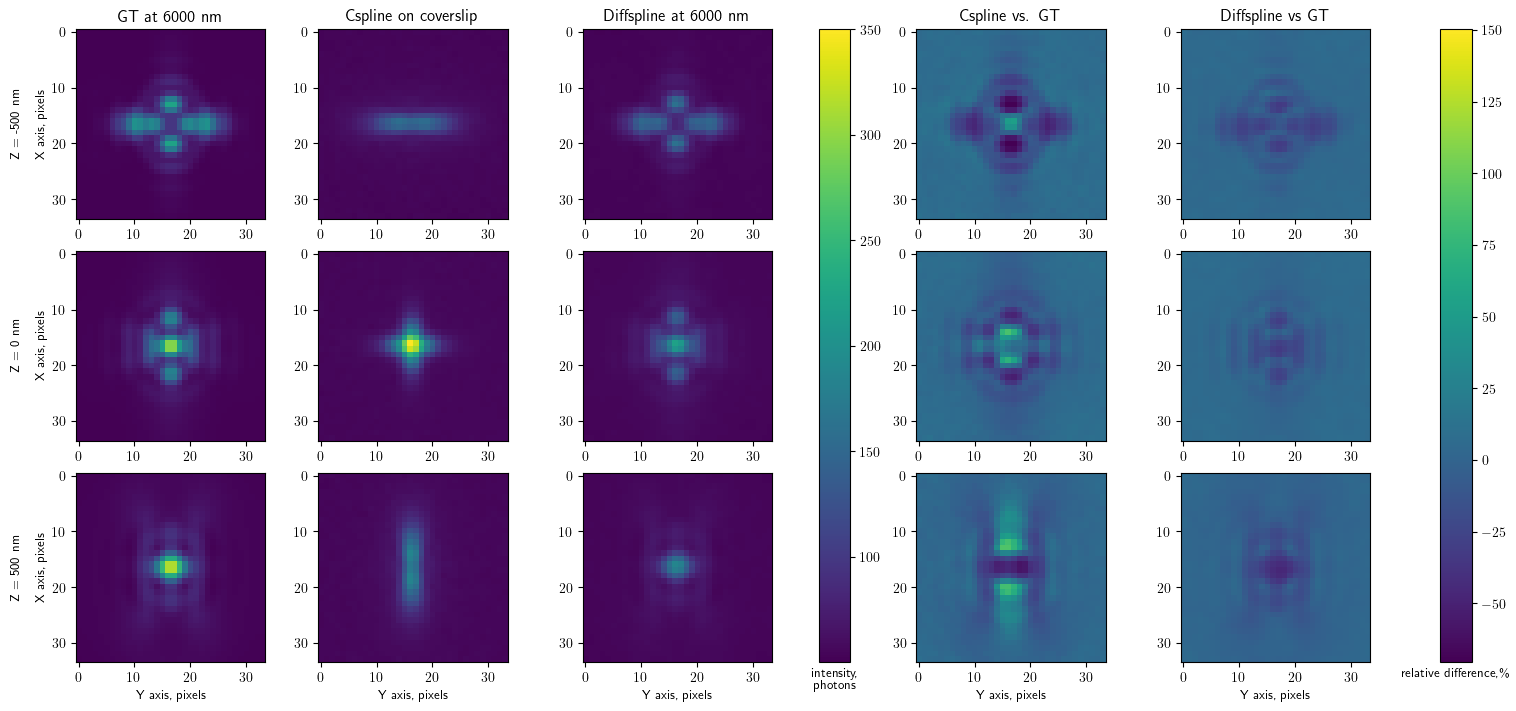

subcol=0, col=0	min=1721.348926867171, max=3681.5930270531812, avg=2141.176470588235
subcol=1, col=0	min=1721.6563151430141, max=4005.323947050769, avg=2141.176470588235
subcol=0, col=1	min=1855.7020263671875, max=4218.67724609375, avg=2126.1233009689413
subcol=1, col=1	min=1834.59912109375, max=4198.62646484375, avg=2126.1233062655274
subcol=0, col=2	min=1810.8697509765625, max=3190.787841796875, avg=2124.696618588358
subcol=1, col=2	min=1814.007080078125, max=3486.007080078125, avg=2124.6966228896126
subcol=0, col=3	min=-27.090345721072215, max=20.590298846621337, avg=6.992078875518851
subcol=1, col=3	min=-28.31268918210051, max=13.2575855160601, avg=5.259572331478212
subcol=0, col=4	min=-22.36245046298489, max=7.679256918238777, avg=5.455926761605483
subcol=1, col=4	min=-22.289522434405264, max=7.448622668357756, avg=4.802719318911576


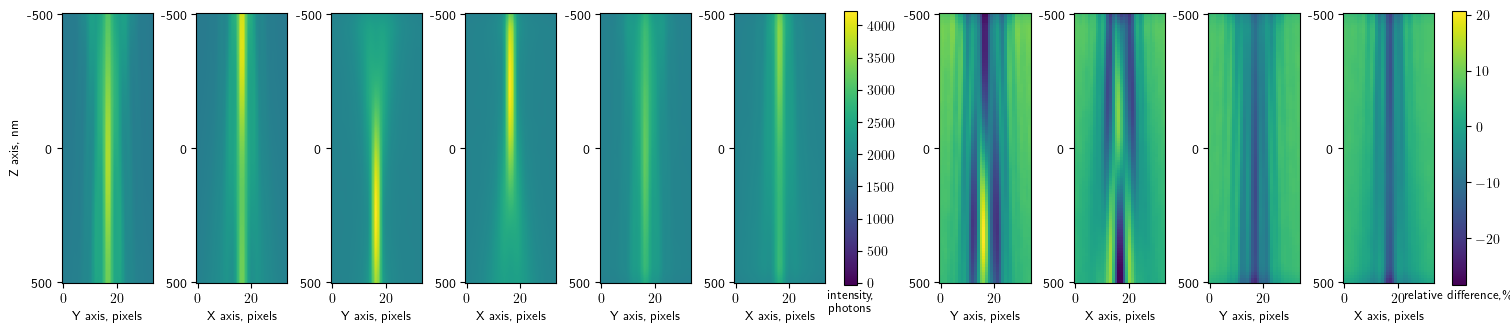

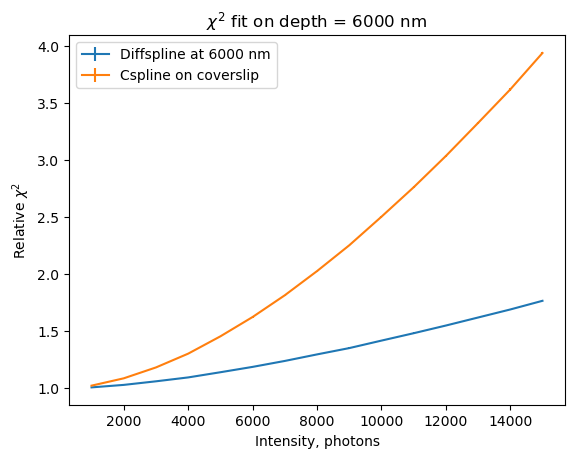

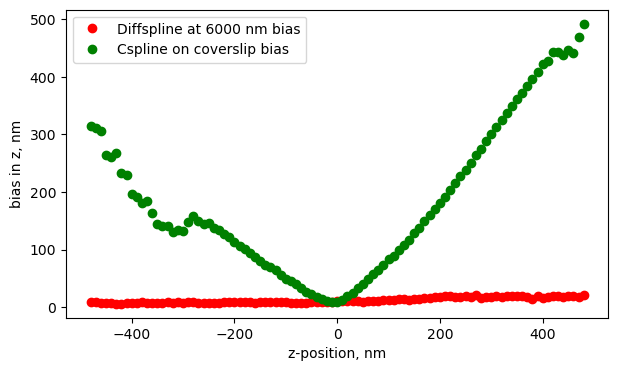

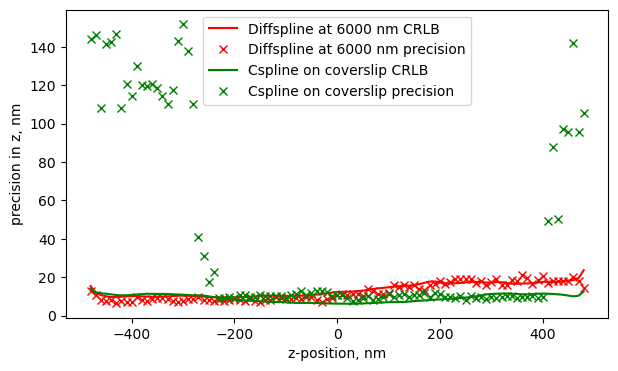

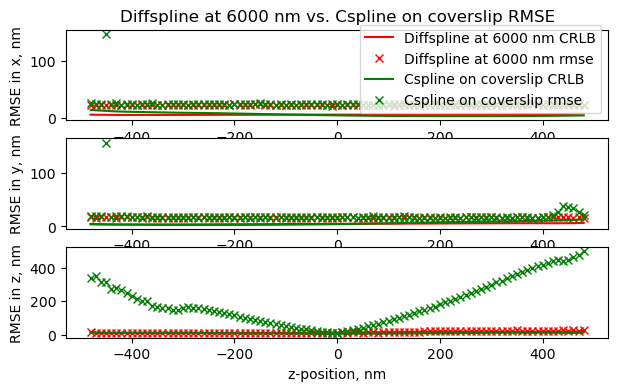

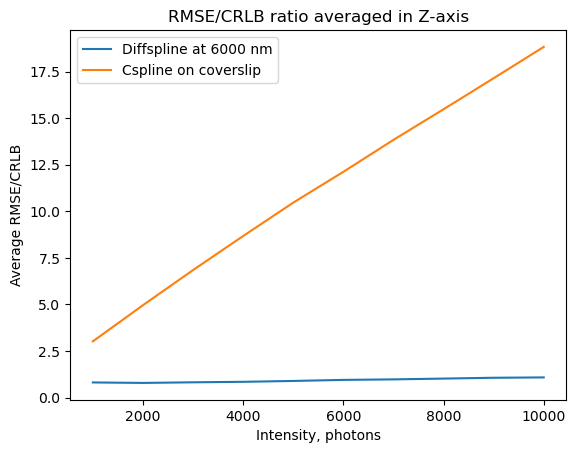

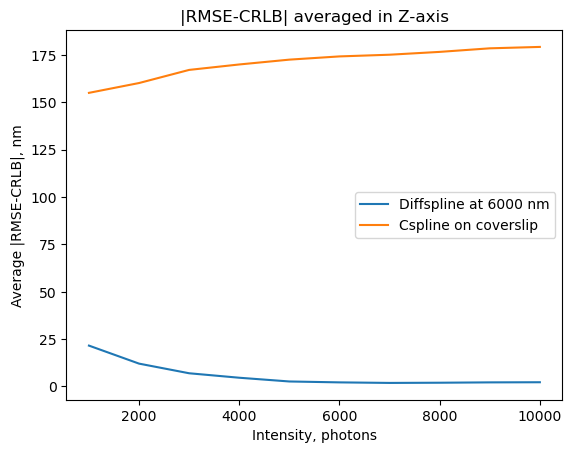

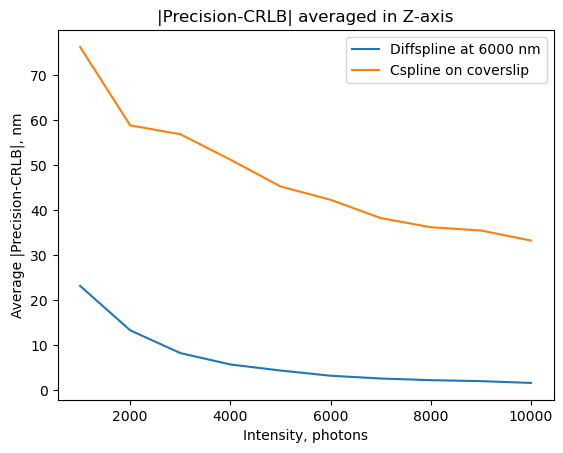

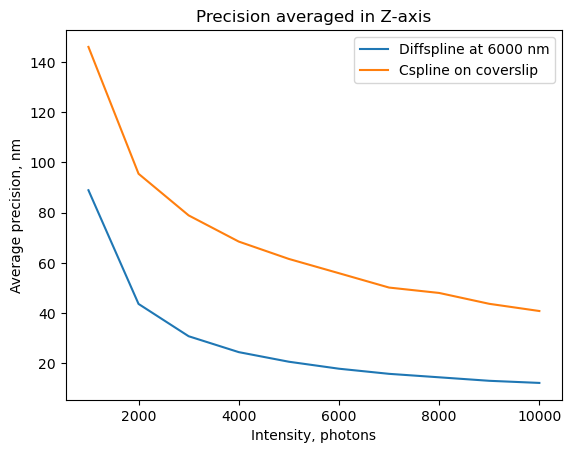

In [15]:
from service_functions.estimation import show_estims_for_depths

I = 10000
bg = 50
iterations = 100
n_samples = 100
damp = 10
roipos_dfspl=(0,0)#(-0.15,-0.25)#(-0.5,0.5)
roipos_smap=(0,0) #(-0.5,0.5)
plot_estimations = False
basic_labels=[f'Diffspline at {depth} nm', 'Cspline on coverslip']
zrange_lim=(2,-2) #(3,-4)


make_psf_figure([base_psf, smap_psfmodel, diffspline_psfmodel], difference_base=0, 
                labels=[f"GT at {depth} nm"]+basic_labels[::-1]+['Cspline vs. GT','Diffspline vs GT'],
                plt_range='auto', figsize1=(15,7),figsize2=(15,7), usetex=True, roiposs=[0, roipos_smap, roipos_dfspl])

chisq_diff, chisq_smap = get_chisq_over_intensity(diffspline_psfmodel, smap_psfmodel, base_psf, 
                                                  zrange=(None,None),roichange=(None, None), roiposs=[roipos_dfspl, roipos_smap],
                                                  bg=50, int_start=1000, int_stop=15000, int_nsteps=15, 
                                                  plot=True, depth=depth, labels=basic_labels)

plot_bias([diffspline_psfmodel, smap_psfmodel], base_folder, depth, I, bg, roiposs=[roipos_dfspl, roipos_smap], 
          zrange_lim=zrange_lim, damp=damp, iterations=iterations, n_samples=n_samples,
          figsize=(7,4), labels=basic_labels, plot_estimations=plot_estimations, plot_rmse=False)

plot_precision_with_crlb([diffspline_psfmodel, smap_psfmodel], base_folder, depth, I, bg, roiposs=[roipos_dfspl, roipos_smap], 
                         zrange_lim=zrange_lim, damp=damp, iterations=iterations, n_samples=n_samples,
                         figsize=(7,4), labels=basic_labels, plot_estimations=plot_estimations)#, zlimit=(0,40))

plot_rmse([diffspline_psfmodel, smap_psfmodel], base_folder, depth, I, bg, roiposs=[roipos_dfspl, roipos_smap], 
          zrange_lim=zrange_lim, damp=damp, iterations=iterations, n_samples=n_samples,
          figsize=(7,4), labels=basic_labels, plot_estimations=plot_estimations)

calculate_axial_rmsebycrlb_over_intensity([diffspline_psfmodel, smap_psfmodel], base_folder, depth, bg, labels=basic_labels, 
                                   damp=damp, iterations=iterations, n_samples=n_samples,
                                   roiposs=[roipos_dfspl, roipos_smap], zrange_lim=zrange_lim,
                                   int_start=1000, int_stop=10000, int_nsteps=10,
                                   plot_estimations=False, plot_gaps=True);
calculate_axial_rmsemincrlb_over_intensity([diffspline_psfmodel, smap_psfmodel], base_folder, depth, bg, labels=basic_labels, 
                                   damp=damp, iterations=iterations, n_samples=n_samples,
                                   roiposs=[roipos_dfspl, roipos_smap], zrange_lim=zrange_lim,
                                   int_start=1000, int_stop=10000, int_nsteps=10,
                                   plot_estimations=False, plot_gaps=True);
calculate_axial_gap_over_intensity([diffspline_psfmodel, smap_psfmodel], base_folder, depth, bg, labels=basic_labels, 
                                   damp=damp, iterations=iterations, n_samples=n_samples,
                                   roiposs=[roipos_dfspl, roipos_smap], zrange_lim=zrange_lim,
                                   int_start=1000, int_stop=10000, int_nsteps=10,
                                   plot_estimations=False, plot_gaps=True);
calculate_precision_over_intensity([diffspline_psfmodel, smap_psfmodel], base_folder, depth, bg, labels=basic_labels, 
                                   damp=damp, iterations=iterations, n_samples=n_samples,
                                   roiposs=[roipos_dfspl, roipos_smap], zrange_lim=zrange_lim,
                                   int_start=1000, int_stop=10000, int_nsteps=10,
                                   plot_estimations=False, plot_gaps=True);

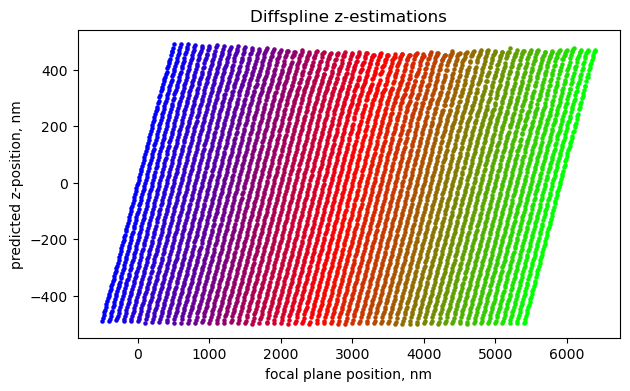

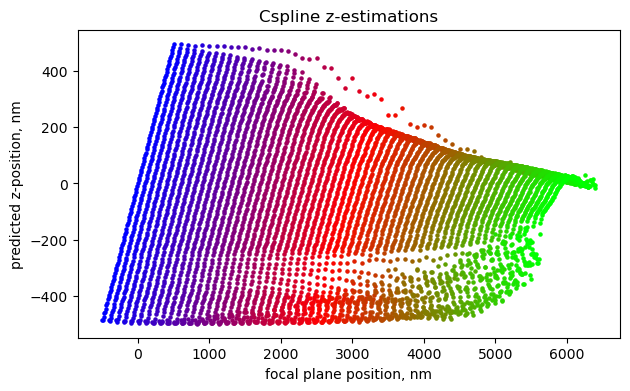

In [16]:
I = 10000
bg = 50

iterations = 100
n_samples = 100
damp = 10

plot_estimations = False
basic_labels=[f'Diffspline at {depth} nm', 'Cspline on coverslip']
zrange_lim=(2,-2) #(3,-4)

depthrange = np.arange(0,6000,100)

show_estims_for_depths('', depthrange, base_folder, I, bg, title='Diffspline',
          damp=damp, iterations=iterations, n_samples=n_samples, figsize=(7,4),
          plot_estimations=plot_estimations, roisize=roisize)

show_estims_for_depths(smap_psfmodel, depthrange, base_folder, I, bg, title='Cspline', 
          damp=damp, iterations=iterations, n_samples=n_samples, figsize=(7,4),
          plot_estimations=plot_estimations)

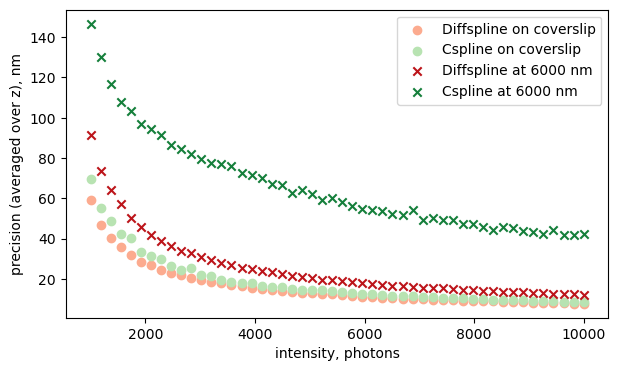

In [17]:
depth=6000
smap_depth=0
roisize=34

roipos_dfspl=(0,0)
roipos_smap=(0,0)
depths = [0,6000]
markers = ['o', 'x']

#smap_psfmodel = load_psfmodel(f'{base_folder}/astig_PSF_smooth_sph{smap_depth:04d}_3Dcorr.mat', roisize=roisize)

cmap_cspl = plt.colormaps['Greens'](np.linspace(0.3, 0.8, num=len(depths)))
cmap_dfspl = plt.colormaps['Reds'](np.linspace(0.3, 0.8, num=len(depths)))
cmaps = [cmap_dfspl, cmap_cspl]

plt.figure(figsize=(7,4))

for j,depth in enumerate(depths):
    basic_labels=[f'Diffspline {["on coverslip" if depth == smap_depth else "at "+str(depth)+" nm"][0]}', f'Cspline {["on coverslip" if depth == smap_depth else "at "+str(depth)+" nm"][0]}']
    base_psf,_ = load_matlab_matpsf(f'{base_folder}/astig_PSF_base_sph{depth:04d}.mat')
    dfspl_name =  f'{base_folder}/astig_PSF_diffspline_dp{depth:04d}.mat'
    diffspline_psfmodel = load_psfmodel(dfspl_name, roisize=roisize)
    prec = calculate_precision_over_intensity([diffspline_psfmodel, smap_psfmodel], base_folder, depth, bg, labels=basic_labels, 
                                   damp=damp, iterations=iterations, n_samples=n_samples,
                                   roiposs=[roipos_dfspl, roipos_smap], zrange_lim=zrange_lim,
                                   int_start=1000, int_stop=10000, int_nsteps=50,
                                   plot_estimations=False, plot_gaps=False);
    for i, val in enumerate(prec):
        plt.scatter(val.keys(), np.array(list(val.values())), marker=markers[j], label=basic_labels[i], color=cmaps[i][j])

plt.xlabel('intensity, photons')
plt.ylabel('precision (averaged over z), nm')
plt.legend()
plt.show()

## Violin and box plots

['data/example/astig_smooth_sph0900_3Dcorr.mat', 'data/example/astig_smooth_sph1000_3Dcorr.mat', 'data/example/astig_smooth_sph1100_3Dcorr.mat', 'data/example/astig_smooth_sph1200_3Dcorr.mat']
Depths in inital stack:  900 1000 1100 1200
['data/example/astig_smooth_sph0700_3Dcorr.mat', 'data/example/astig_smooth_sph1000_3Dcorr.mat', 'data/example/astig_smooth_sph1300_3Dcorr.mat', 'data/example/astig_smooth_sph1600_3Dcorr.mat']
Depths in inital stack:  700 1000 1300 1600
['data/example/astig_smooth_sph0500_3Dcorr.mat', 'data/example/astig_smooth_sph1000_3Dcorr.mat', 'data/example/astig_smooth_sph1500_3Dcorr.mat', 'data/example/astig_smooth_sph2000_3Dcorr.mat']
Depths in inital stack:  500 1000 1500 2000
['data/example/astig_smooth_sph0300_3Dcorr.mat', 'data/example/astig_smooth_sph1000_3Dcorr.mat', 'data/example/astig_smooth_sph1700_3Dcorr.mat', 'data/example/astig_smooth_sph2400_3Dcorr.mat']
Depths in inital stack:  300 1000 1700 2400
['data/example/astig_smooth_sph0000_3Dcorr.mat', 'da

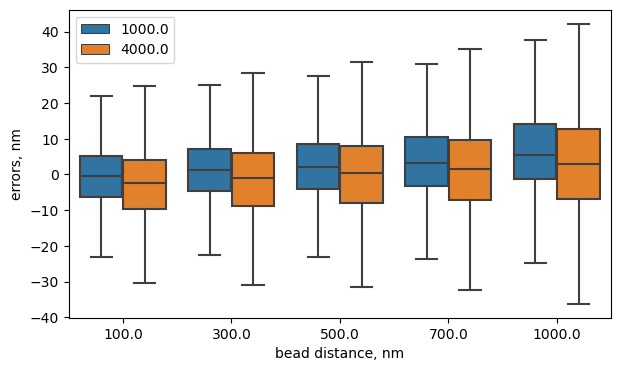

CPU times: total: 3min 55s
Wall time: 20min 35s


In [21]:
%%time
# boxplot version without the absolute errors

depths=[1000,4000]
deltas=[100,300,500,700,1000]
num_evals=10
zrange_lim=(2,-2)
figsize=(7,4)

data = plot_metrics_over_deltas(depths=depths, deltas=deltas, num_evals=num_evals, base_folder=base_folder, 
                         figsize=figsize, zrange_lim=zrange_lim);

In [22]:
print(data.groupby(['bead distance, nm', 'depth'])['errors, nm'].mean())
print(data.groupby(['bead distance, nm', 'depth'])['errors, nm'].median())
print(data.groupby(['bead distance, nm', 'depth'])['errors, nm'].min())
print(data.groupby(['bead distance, nm', 'depth'])['errors, nm'].max())
print(data.groupby(['bead distance, nm', 'depth'])['errors, nm'].std())

bead distance, nm  depth 
100.0              1000.0   -1.115824
                   4000.0   -4.473562
300.0              1000.0    0.951559
                   4000.0   -3.437182
500.0              1000.0    2.054282
                   4000.0   -2.274137
700.0              1000.0    3.473378
                   4000.0   -0.967976
1000.0             1000.0    6.435688
                   4000.0    0.060425
Name: errors, nm, dtype: float64
bead distance, nm  depth 
100.0              1000.0   -0.384333
                   4000.0   -2.252070
300.0              1000.0    1.167971
                   4000.0   -0.850844
500.0              1000.0    2.129782
                   4000.0    0.339837
700.0              1000.0    3.284546
                   4000.0    1.643208
1000.0             1000.0    5.480703
                   4000.0    2.977544
Name: errors, nm, dtype: float64
bead distance, nm  depth 
100.0              1000.0    -62.802504
                   4000.0   -113.577260
300.0           